In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langgraph.graph import StateGraph, END
from typing import Annotated, TypedDict, List
import operator
from langchain_core.messages import AnyMessage, SystemMessage, AIMessage, HumanMessage
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_openai import ChatOpenAI
import contextlib


In [3]:
memory = SqliteSaver.from_conn_string(":memory:")
checkpointer = contextlib.ExitStack().enter_context(memory)

In [4]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [5]:
model = ChatOpenAI(model="gpt-3.5-turbo",temperature=0)


In [6]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [7]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [8]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [9]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [10]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [11]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

/Users/jaswanthmannem/Desktop/MyProjects/AiAgents_LangGraph/agents/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

In [13]:
def plan_node(state: AgentState):
    messages = [SystemMessage(content=PLAN_PROMPT),HumanMessage(content=state["task"])]
    response = model.invoke(messages)
    return {"plan":response.content}

In [27]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke(
        [SystemMessage(content=RESEARCH_PLAN_PROMPT),HumanMessage(content=state["task"])]
    )
    content = state.get("content", [])
    for q in queries.queries:
        response = tavily.search(query=q,max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content":content}

In [28]:
def generation_node(state: AgentState):
    content = "\n\n".join(state["content"] or [])
    user_message = HumanMessage(content=f"{state['task']}\n\n. Here is my plan\n\n{state['plan']}")
    messages = [SystemMessage(content=WRITER_PROMPT.format(content=content)),user_message]
    response = model.invoke(messages)
    return {
        "draft":response.content,
        "revision_number":state.get("revision_number",1) + 1
    }

In [29]:
def reflection_node(state: AgentState):
    messages = [SystemMessage(content=REFLECTION_PROMPT),HumanMessage(content=state["draft"])]
    response = model.invoke(messages)
    return {"critique":response.content}

In [30]:
def research_crtique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke(
        [SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),HumanMessage(content=state["critique"])]
    )
    content = state.get("content", [])
    for q in queries.queries:
        response = tavily.search(query=q,max_results=2)
        for r in response["results"]:
            content.append(r['content'])
    return {"content":content}

In [31]:
def should_continue_state(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [32]:
builder = StateGraph(AgentState)

In [33]:
builder.add_node("planner",plan_node)
builder.add_node("generate",generation_node)
builder.add_node("reflect",reflection_node)
builder.add_node("research_plan",research_plan_node)
builder.add_node("research_crtique",research_crtique_node)

In [34]:
builder.set_entry_point("planner")

In [35]:
builder.add_conditional_edges("generate",should_continue_state,{END:END,"reflect":"reflect"})

In [36]:
builder.add_edge("planner","research_plan")
builder.add_edge("research_plan","generate")
builder.add_edge("reflect","research_crtique")
builder.add_edge("research_crtique","generate")


In [37]:
graph = builder.compile(checkpointer=checkpointer)

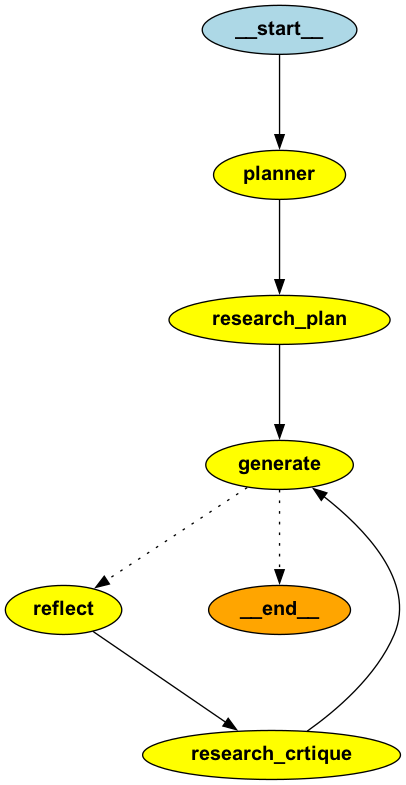

In [38]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [39]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': 'I. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Thesis statement: Exploring the differences between Langchain and Langsmith\n\nII. Langchain\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIII. Langsmith\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIV. Comparison between Langchain and Langsmith\n    A. Technology stack\n    B. Scalability\n    C. Security\n    D. Flexibility\n    E. Performance\n\nV. Conclusion\n    A. Recap of main differences between Langchain and Langsmith\n    B. Implications for future development and adoption\n    C. Final thoughts on the significance of these technologies\n\nNotes:\n- Ensure a clear and concise explanation of both Langchain and Langsmith.\n- Provide specific examples of use cases to illustrate

/Users/jaswanthmannem/Desktop/MyProjects/AiAgents_LangGraph/agents/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1624: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/Users/jaswanthmannem/Desktop/MyProjects/AiAgents_LangGraph/agents/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


{'research_plan': {'content': ['Langchain vs Langsmith: Unpacking the AI Language Model Showdown – Be on the Right Side of Change Langchain vs Langsmith: Unpacking the AI Language Model Showdown If Langchain is the engine, LangSmith is the dashboard helping you monitor and debug the performance of your LLM applications. It’s about bringing your ideas from initial prototype to a robust production environment, using tools like LangSmith for crafting and LangChain for deployment. Remember, while LangSmith helps you build, test, and debug your prototype, LangChain offers the structure for deploying and monitoring your final product in a live environment. Whether you’re trying to figure out which tool fits your needs or you’re just getting started with language model automation, these FAQs will help shed light on the common curiosities about Langchain and LangSmith.', 'But when it’s time to troubleshoot or improve your workflows, LangSmith steps in with tools to analyze, debug, and optimize

/Users/jaswanthmannem/Desktop/MyProjects/AiAgents_LangGraph/agents/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1624: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/Users/jaswanthmannem/Desktop/MyProjects/AiAgents_LangGraph/agents/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


{'research_crtique': {'content': ['Langchain vs Langsmith: Unpacking the AI Language Model Showdown – Be on the Right Side of Change Langchain vs Langsmith: Unpacking the AI Language Model Showdown If Langchain is the engine, LangSmith is the dashboard helping you monitor and debug the performance of your LLM applications. It’s about bringing your ideas from initial prototype to a robust production environment, using tools like LangSmith for crafting and LangChain for deployment. Remember, while LangSmith helps you build, test, and debug your prototype, LangChain offers the structure for deploying and monitoring your final product in a live environment. Whether you’re trying to figure out which tool fits your needs or you’re just getting started with language model automation, these FAQs will help shed light on the common curiosities about Langchain and LangSmith.', 'But when it’s time to troubleshoot or improve your workflows, LangSmith steps in with tools to analyze, debug, and optim